# Age of Empires IV - Matchmaking System

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load ranked games data
ranked_games_df = pd.read_json("../dataset/games_rm_1v1_s8.json")

# Load leaderboards data
leaderboard_df = pd.read_csv("../dataset/leadersboards_rm_1v1_elo.csv")

display(ranked_games_df.head())
display(ranked_games_df.info())

display(leaderboard_df.head())
display(leaderboard_df.info())

,game_id,started_at,finished_at,duration,map_id,map,kind,server,patch,teams
0,137248000,2024-07-18 18:04:10+00:00,2024-07-18 18:34:00+00:00,1790,2129132,Cliffside,rm_1v1,USA (E),11.0.782.0,"[[{'profile_id': 8313452, 'result': 'loss', 'c..."
1,137248046,2024-07-18 18:04:34+00:00,2024-07-18 18:20:34+00:00,960,2064632,The Pit,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 8558578, 'result': 'win', 'ci..."
2,137248062,2024-07-18 18:04:35+00:00,2024-07-18 18:18:31+00:00,836,2141179,Rocky River,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 20006865, 'result': 'win', 'c..."
3,137248220,2024-07-18 18:06:07+00:00,2024-07-18 18:51:37+00:00,2730,2141179,Rocky River,rm_1v1,UK,11.0.782.0,"[[{'profile_id': 7946550, 'result': 'win', 'ci..."
4,137248210,2024-07-18 18:06:05+00:00,2024-07-18 18:30:50+00:00,1485,163361,Dry Arabia,rm_1v1,USA (E),11.0.782.0,"[[{'profile_id': 1610803, 'result': 'loss', 'c..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069766 entries, 0 to 1069765
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   game_id      1069766 non-null  int64              
 1   started_at   1069766 non-null  datetime64[ns, UTC]
 2   finished_at  1069766 non-null  datetime64[ns, UTC]
 3   duration     1069766 non-null  int64              
 4   map_id       1069766 non-null  int64              
 5   map          1069766 non-null  object             
 6   kind         1069766 non-null  object             
 7   server       1069766 non-null  object             
 8   patch        1069766 non-null  object             
 9   teams        1069766 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(3), object(5)
memory usage: 81.6+ MB


None

,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,NaN,by
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,NaN,rs
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,NaN,es
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,NaN,cn
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,NaN,ca


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139492 entries, 0 to 139491
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rank          139492 non-null  int64  
 1   name          139490 non-null  object 
 2   profile_id    139492 non-null  int64  
 3   rating        139492 non-null  int64  
 4   games_count   139492 non-null  int64  
 5   wins_count    139492 non-null  int64  
 6   last_game_at  139492 non-null  object 
 7   rank_level    0 non-null       float64
 8   country       136325 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 9.6+ MB


None

## Data Preprocessing

### Feature Engineering
Creating new features from `ranked_games_df` and `leaderboard_df` datasets. Then create a new dataset `players_df` with the following features:
- `rank`: player's rank in the leaderboard
- `profile_id`: player's Steam profile ID
- `name`: player's name
- `rating`: Player's ELO rating
- `games_count`: number of games played
- `wins_count`: number of games won
- `last_game_at`: timestamp of the last game played
- `rank_level`: player's rank level in the leaderboard
- `country`: player's country
- `win_rate`: player's win rate
- `avg_mmr_diff_10`: average MMR difference in the last 10 games
- `avg_mmr_diff_50`: average MMR difference in the last 50 games
- `avg_opp_mmr`: average opponent MMR
- `avg_game_length`: average game length in seconds
- `common_civ`: most common civilization, based on player's entire game history

In [2]:
# Create rank_level feature which is player"s rank in the game and assign it to each player based on their rating
# Rank level to elo mapping
rank_levels: dict[str, tuple[int, int]] = {
    "Bronze 1": (0, 0),
    "Bronze 2": (400, 1),
    "Bronze 3": (450, 2),
    "Silver 1": (500, 3),
    "Silver 2": (600, 4),
    "Silver 3": (650, 5),
    "Gold 1": (700, 6),
    "Gold 2": (800, 7),
    "Gold 3": (900, 8),
    "Platinum 1": (1000, 9),
    "Platinum 2": (1100, 10),
    "Platinum 3": (1150, 11),
    "Diamond 1": (1200, 12),
    "Diamond 2": (1300, 13),
    "Diamond 3": (1350, 14),
    "Conqueror 1": (1400, 15),
    "Conqueror 2": (1500, 16),
    "Conqueror 3": (1600, 17),
}

# Mapping function to get rank level name based on rating
def get_rank_level(rating: int) -> str:
    for rank, threshold in reversed(rank_levels.items()):
        if rating >= threshold[0]:
            return rank
    return "Unranked"

# Mapping function to get rank level encoded value based on rating
def get_rank_level_encoded(rating: int) -> int:
    for _, threshold in reversed(rank_levels.items()):
        if rating >= threshold[0]:
            return threshold[1]
    return 0


# Assign rank level to each player based on their rating
leaderboard_df["rank_level"] = leaderboard_df["rating"].apply(get_rank_level)
leaderboard_df["rank_level_encoded"] = leaderboard_df["rating"].apply(get_rank_level_encoded)

display(leaderboard_df.head())

print("Missing values in ranked games data:")
print(ranked_games_df.isnull().sum())

print("\nMissing values in leaderboards data:")
print(leaderboard_df.isnull().sum())

,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country,rank_level_encoded
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,Conqueror 3,by,17
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,Conqueror 3,rs,17
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,Conqueror 3,es,17
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,Conqueror 3,cn,17
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,Conqueror 3,ca,17


Missing values in ranked games data:
game_id        0
started_at     0
finished_at    0
duration       0
map_id         0
map            0
kind           0
server         0
patch          0
teams          0
dtype: int64

Missing values in leaderboards data:
rank                     0
name                     2
profile_id               0
rating                   0
games_count              0
wins_count               0
last_game_at             0
rank_level               0
country               3167
rank_level_encoded       0
dtype: int64


### Create player games dataframe from the ranked_games_df dataset
Since the `ranked_games_df` dataset contains a complex structure with `teams` column that is a JSON array, we need to flatten the dataset to create a new dataframe `player_games_df` with the following features:
- `game_id`: game ID
- `player_id`: player's Steam profile ID
- `team_id`: team ID
- `started_dt`: timestamp of the game start
- `finished_dt`: timestamp of the game finish
- `duration`: game duration in seconds
- `mmr`: player's MMR
- `mmr_diff`: MMR difference
- `civilization`: player's civilization
- `result`: game result (win/loss)

In [3]:
player_rows: list[dict] = []

for idx, row in ranked_games_df.iterrows():
    game_id = row["game_id"]
    started_at = row["started_at"]
    finished_at = row["finished_at"]
    duration = row["duration"]

    # Convert time strings to datetime
    started_dt = pd.to_datetime(started_at)
    finished_dt = pd.to_datetime(finished_at)
    
    # "teams" is a list of lists. Each sub-list is a team.
    # For a 1v1, it will be something like [[{playerA_info}], [{playerB_info}]]
    for team in row["teams"]:
        for player_info in team:
            player_info: dict

            p_id = player_info["profile_id"]
            mmr = player_info.get("mmr", np.nan)
            mmr_diff = player_info.get("mmr_diff", np.nan)
            civ = player_info.get("civilization", None)
            result = player_info.get("result", None)

            player_rows.append({
                "profile_id": p_id,
                "game_id": game_id,
                "started_dt": started_dt,
                "finished_dt": finished_dt,
                "duration": duration,
                "mmr": mmr,
                "mmr_diff": mmr_diff,
                "civilization": civ,
                "result": result
            })

player_games_df = pd.DataFrame(player_rows)

display(player_games_df.head())
display(player_games_df.info())

print("Missing values in player_games_df:")
print(player_games_df.isnull().sum())

,profile_id,game_id,started_dt,finished_dt,duration,mmr,mmr_diff,civilization,result
0,8313452,137248000,2024-07-18 18:04:10+00:00,2024-07-18 18:34:00+00:00,1790,992.0,-16.0,english,loss
1,14416582,137248000,2024-07-18 18:04:10+00:00,2024-07-18 18:34:00+00:00,1790,984.0,16.0,ottomans,win
2,8558578,137248046,2024-07-18 18:04:34+00:00,2024-07-18 18:20:34+00:00,960,NaN,NaN,byzantines,win
3,14931201,137248046,2024-07-18 18:04:34+00:00,2024-07-18 18:20:34+00:00,960,1176.0,-20.0,delhi_sultanate,loss
4,20006865,137248062,2024-07-18 18:04:35+00:00,2024-07-18 18:18:31+00:00,836,827.0,12.0,zhu_xis_legacy,win


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139532 entries, 0 to 2139531
Data columns (total 9 columns):
 #   Column        Dtype              
---  ------        -----              
 0   profile_id    int64              
 1   game_id       int64              
 2   started_dt    datetime64[ns, UTC]
 3   finished_dt   datetime64[ns, UTC]
 4   duration      int64              
 5   mmr           float64            
 6   mmr_diff      float64            
 7   civilization  object             
 8   result        object             
dtypes: datetime64[ns, UTC](2), float64(2), int64(3), object(2)
memory usage: 146.9+ MB


None

Missing values in player_games_df:
profile_id           0
game_id              0
started_dt           0
finished_dt          0
duration             0
mmr             133772
mmr_diff        142387
civilization         0
result               0
dtype: int64


### Compute Aggregated Features
Compute per player aggregated features from the `player_games_df`:
- Average MMR change over last 10 games
- Average MMR change over last 50 games
- Average opponent MMR
- Average game length
- Most common civilization picks

In [4]:
# To get the opponent MMR, for each game and player, we need the other player(s) in that game.
# For 1v1, that"s straightforward:
# We"ll merge player_games_df with itself by game_id to find opponent rows.
opponent_merge = player_games_df[["game_id", "profile_id", "mmr"]]
opponent_merge = opponent_merge.rename(columns={"profile_id":"opp_profile_id", "mmr":"opp_mmr"})

player_games_merged = player_games_df.merge(opponent_merge, on="game_id", how="left")

# This creates pairs (A-A and A-B and B-A). We only want rows where profile_id != opp_profile_id:
player_games_merged = player_games_merged[player_games_merged["profile_id"] != player_games_merged["opp_profile_id"]]

# Now each row has player and their opponent"s MMR. For 1v1 matches, this should give a single opponent row per match.
# Sort by finished_dt to identify last 10 games
player_games_merged = player_games_merged.sort_values(by=["profile_id", "finished_dt"])

# Define a helper function to get last 10 games stats:
def agg_player_stats(df: pd.DataFrame) -> pd.Series:
    # df is all games for a single player
    # Take last 10 games
    last_10 = df.tail(10)

    # Take last 50 games
    last_50 = df.tail(50)
    
    avg_mmr_diff_10 = last_10["mmr_diff"].mean() if not last_10.empty else np.nan
    avg_mmr_diff_50 = last_50["mmr_diff"].mean() if not last_50.empty else np.nan
    avg_mmr = df["mmr"].mean() if not df["mmr"].empty else np.nan
    avg_opp_mmr = last_10["opp_mmr"].mean() if not last_10.empty else np.nan
    avg_game_length = last_10["duration"].mean() if not last_10.empty else np.nan
    
    # Most common civ among the player"s entire history
    most_common_civ = df["civilization"].mode().iloc[0] if not df["civilization"].empty else None

    return pd.Series({
        "avg_mmr_diff_10": avg_mmr_diff_10,
        "avg_mmr_diff_50": avg_mmr_diff_50,
        "avg_mmr": avg_mmr,
        "avg_opp_mmr": avg_opp_mmr,
        "avg_game_length": avg_game_length,
        "common_civ": most_common_civ
    })

players_aggregates = player_games_merged.groupby("profile_id").apply(agg_player_stats).reset_index()
display(players_aggregates.head())

C:\Users\admin\AppData\Local\Temp\ipykernel_15364\2017262449.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  players_aggregates = player_games_merged.groupby("profile_id").apply(agg_player_stats).reset_index()


,profile_id,avg_mmr_diff_10,avg_mmr_diff_50,avg_mmr,avg_opp_mmr,avg_game_length,common_civ
0,178,-12.1,3.300000,762.050000,808.444444,993.9,english
1,533,NaN,NaN,NaN,897.000000,1601.6,japanese
2,695,NaN,NaN,NaN,1071.000000,1186.0,holy_roman_empire
3,798,-0.4,-1.944444,1259.777778,1244.500000,1268.7,order_of_the_dragon
4,894,6.1,0.000000,961.727273,961.000000,1763.5,rus


### Merge new aggregated features into the `leaderboard_df`

In [5]:
players_df = leaderboard_df.merge(players_aggregates, on="profile_id", how="left")

# Calculate win rate for each player
players_df["win_rate"] = players_df["wins_count"] / players_df["games_count"]

# Fill missing values if any players don`t have matches:
players_df["avg_mmr_diff_10"] = players_df["avg_mmr_diff_10"].fillna(0)
players_df["avg_mmr_diff_50"] = players_df["avg_mmr_diff_50"].fillna(0)
players_df["avg_opp_mmr"] = players_df["avg_opp_mmr"].fillna(0)
players_df["avg_mmr"] = players_df["avg_mmr"].fillna(0)
players_df["avg_game_length"] = players_df["avg_game_length"].fillna(0)
players_df["common_civ"] = players_df["common_civ"].fillna("unknown")

print("The final enriched players dataset:")
display(players_df.head())
display(players_df.info())

print("Missing values in players_df:")
print(players_df.isnull().sum())

The final enriched players dataset:


,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country,rank_level_encoded,avg_mmr_diff_10,avg_mmr_diff_50,avg_mmr,avg_opp_mmr,avg_game_length,common_civ,win_rate
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,Conqueror 3,by,17,1.7,0.660000,2142.573770,1956.5,1043.9,zhu_xis_legacy,0.648485
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,Conqueror 3,rs,17,4.2,0.240000,2233.368687,1977.7,1536.2,delhi_sultanate,0.856074
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,Conqueror 3,es,17,-3.5,-3.090909,2184.181818,1835.5,982.8,ayyubids,0.860522
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,Conqueror 3,cn,17,-1.3,-0.340000,2163.094891,1745.5,1258.2,japanese,0.711252
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,Conqueror 3,ca,17,2.2,2.702128,2067.808511,1769.6,1192.6,japanese,0.777675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139492 entries, 0 to 139491
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   rank                139492 non-null  int64  
 1   name                139490 non-null  object 
 2   profile_id          139492 non-null  int64  
 3   rating              139492 non-null  int64  
 4   games_count         139492 non-null  int64  
 5   wins_count          139492 non-null  int64  
 6   last_game_at        139492 non-null  object 
 7   rank_level          139492 non-null  object 
 8   country             136325 non-null  object 
 9   rank_level_encoded  139492 non-null  int64  
 10  avg_mmr_diff_10     139492 non-null  float64
 11  avg_mmr_diff_50     139492 non-null  float64
 12  avg_mmr             139492 non-null  float64
 13  avg_opp_mmr         139492 non-null  float64
 14  avg_game_length     139492 non-null  float64
 15  common_civ          139492 non-nul

None

Missing values in players_df:
rank                     0
name                     2
profile_id               0
rating                   0
games_count              0
wins_count               0
last_game_at             0
rank_level               0
country               3167
rank_level_encoded       0
avg_mmr_diff_10          0
avg_mmr_diff_50          0
avg_mmr                  0
avg_opp_mmr              0
avg_game_length          0
common_civ               0
win_rate                 0
dtype: int64


### Matches dataset
Now we prepare the `matches_df` dataset for the classification task, which needs to predict the outcome of a match based on the player's features.

In [6]:
match_rows: list[dict] = []

for _, row in ranked_games_df.iterrows():
    teams = row["teams"]
    
    # For 1v1 matches: two sub-lists with one player each
    if len(teams) == 2 and len(teams[0]) == 1 and len(teams[1]) == 1:
        pA = teams[0][0]
        pB = teams[1][0]

        outcome = 1 if pA["result"] == "win" else 0
        match_rows.append({
            "profile_id_A": pA["profile_id"],
            "profile_id_B": pB["profile_id"],
            "outcome_A": outcome
        })

matches_df = pd.DataFrame(match_rows)

# Merge Player Info
player_info = players_df[[
    "profile_id", "rating", "win_rate", 
    "games_count", "wins_count", "rank_level_encoded", 
    "avg_mmr_diff_10", "avg_mmr_diff_50", "avg_mmr", 
    "avg_opp_mmr", "avg_game_length"
]].copy()

columns_to_rename_A = {
    "rating": "rating_A",
    "win_rate": "win_rate_A",
    "games_count": "games_count_A",
    "wins_count": "wins_count_A",
    "rank_level_encoded": "rank_level_encoded_A",
    "avg_mmr_diff_10": "avg_mmr_diff_10_A",
    "avg_mmr_diff_50": "avg_mmr_diff_50_A",
    "avg_mmr": "avg_mmr_A",
    "avg_opp_mmr": "avg_opp_mmr_A",
    "avg_game_length": "avg_game_length_A"
}

columns_to_rename_B = {
    "rating": "rating_B",
    "win_rate": "win_rate_B",
    "games_count": "games_count_B",
    "wins_count": "wins_count_B",
    "rank_level_encoded": "rank_level_encoded_B",
    "avg_mmr_diff_10": "avg_mmr_diff_10_B",
    "avg_mmr_diff_50": "avg_mmr_diff_50_B",
    "avg_mmr": "avg_mmr_B",
    "avg_opp_mmr": "avg_opp_mmr_B",
    "avg_game_length": "avg_game_length_B"
}

# Merge for Player A
matches_df = matches_df.merge(player_info, left_on="profile_id_A", right_on="profile_id", how="left")
matches_df.rename(columns=columns_to_rename_A, inplace=True)
matches_df.drop(columns="profile_id", inplace=True)

# Merge for Player B
matches_df = matches_df.merge(player_info, left_on="profile_id_B", right_on="profile_id", how="left")
matches_df.rename(columns=columns_to_rename_B, inplace=True)
matches_df.drop(columns="profile_id", inplace=True)

display(matches_df.head())
display(matches_df.info())

print("Missing values in matches_df:")
print(matches_df.isnull().sum())

,profile_id_A,profile_id_B,outcome_A,rating_A,win_rate_A,games_count_A,wins_count_A,rank_level_encoded_A,avg_mmr_diff_10_A,avg_mmr_diff_50_A,...,rating_B,win_rate_B,games_count_B,wins_count_B,rank_level_encoded_B,avg_mmr_diff_10_B,avg_mmr_diff_50_B,avg_mmr_B,avg_opp_mmr_B,avg_game_length_B
0,8313452,14416582,0,959.0,0.499676,3090.0,1544.0,8.0,-0.1,0.142857,...,1102.0,0.509434,689.0,351.0,10.0,0.3,0.040000,1047.952941,1107.333333,1194.2
1,8558578,14931201,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1140.0,0.504207,1664.0,839.0,10.0,3.1,0.777778,1191.202469,1208.700000,1413.7
2,20006865,18910322,1,830.0,0.508547,234.0,119.0,7.0,12.7,2.060000,...,708.0,0.499241,1318.0,658.0,6.0,-2.9,-0.980000,725.119734,723.300000,1788.5
3,7946550,17488191,1,634.0,0.477273,264.0,126.0,4.0,-2.9,-3.240000,...,682.0,0.453704,108.0,49.0,5.0,-3.1,0.250000,702.937500,735.700000,1381.0
4,1610803,7798234,0,844.0,0.495935,246.0,122.0,7.0,-3.1,0.300000,...,877.0,0.500000,28.0,14.0,7.0,-0.5,-0.500000,884.000000,869.000000,1306.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069766 entries, 0 to 1069765
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   profile_id_A          1069766 non-null  int64  
 1   profile_id_B          1069766 non-null  int64  
 2   outcome_A             1069766 non-null  int64  
 3   rating_A              1034400 non-null  float64
 4   win_rate_A            1034400 non-null  float64
 5   games_count_A         1034400 non-null  float64
 6   wins_count_A          1034400 non-null  float64
 7   rank_level_encoded_A  1034400 non-null  float64
 8   avg_mmr_diff_10_A     1034400 non-null  float64
 9   avg_mmr_diff_50_A     1034400 non-null  float64
 10  avg_mmr_A             1034400 non-null  float64
 11  avg_opp_mmr_A         1034400 non-null  float64
 12  avg_game_length_A     1034400 non-null  float64
 13  rating_B              1052544 non-null  float64
 14  win_rate_B            1052544 non-

None

Missing values in matches_df:
profile_id_A                0
profile_id_B                0
outcome_A                   0
rating_A                35366
win_rate_A              35366
games_count_A           35366
wins_count_A            35366
rank_level_encoded_A    35366
avg_mmr_diff_10_A       35366
avg_mmr_diff_50_A       35366
avg_mmr_A               35366
avg_opp_mmr_A           35366
avg_game_length_A       35366
rating_B                17222
win_rate_B              17222
games_count_B           17222
wins_count_B            17222
rank_level_encoded_B    17222
avg_mmr_diff_10_B       17222
avg_mmr_diff_50_B       17222
avg_mmr_B               17222
avg_opp_mmr_B           17222
avg_game_length_B       17222
dtype: int64


### Drop missing values in the `matches_df` dataset
We can safely drop the missing values in the `matches_df` dataset, because those are new players that haven't played any games yet.

In [7]:
print("Shape of matches_df before dropping rows with missing values:", matches_df.shape)

matches_df.dropna(inplace=True)

print("Shape of matches_df after dropping rows with missing values:", matches_df.shape)
print("Missing values in matches_df after dropping rows with missing values:")
print(matches_df.isnull().sum())

Shape of matches_df before dropping rows with missing values: (1069766, 23)
Shape of matches_df after dropping rows with missing values: (1018525, 23)
Missing values in matches_df after dropping rows with missing values:
profile_id_A            0
profile_id_B            0
outcome_A               0
rating_A                0
win_rate_A              0
games_count_A           0
wins_count_A            0
rank_level_encoded_A    0
avg_mmr_diff_10_A       0
avg_mmr_diff_50_A       0
avg_mmr_A               0
avg_opp_mmr_A           0
avg_game_length_A       0
rating_B                0
win_rate_B              0
games_count_B           0
wins_count_B            0
rank_level_encoded_B    0
avg_mmr_diff_10_B       0
avg_mmr_diff_50_B       0
avg_mmr_B               0
avg_opp_mmr_B           0
avg_game_length_B       0
dtype: int64


## Visualizations

### 1. Distribution of Player MMR

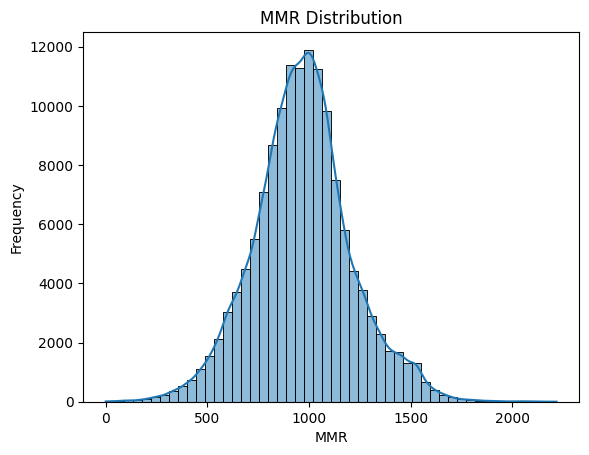

In [33]:
sns.histplot(leaderboard_df["rating"], bins=50, kde=True)
plt.title("MMR Distribution")
plt.xlabel("MMR")
plt.ylabel("Frequency")
plt.show()

### 2. Distribution of Players Across Rank Levels

Number of players in each rank level:


,rank_level,player_count
14,Bronze 1,1502
17,Bronze 2,862
15,Bronze 3,1323
7,Silver 1,4830
9,Silver 2,3845
8,Silver 3,4825
3,Gold 1,13846
2,Gold 2,21604
0,Gold 3,25965
1,Platinum 1,24720


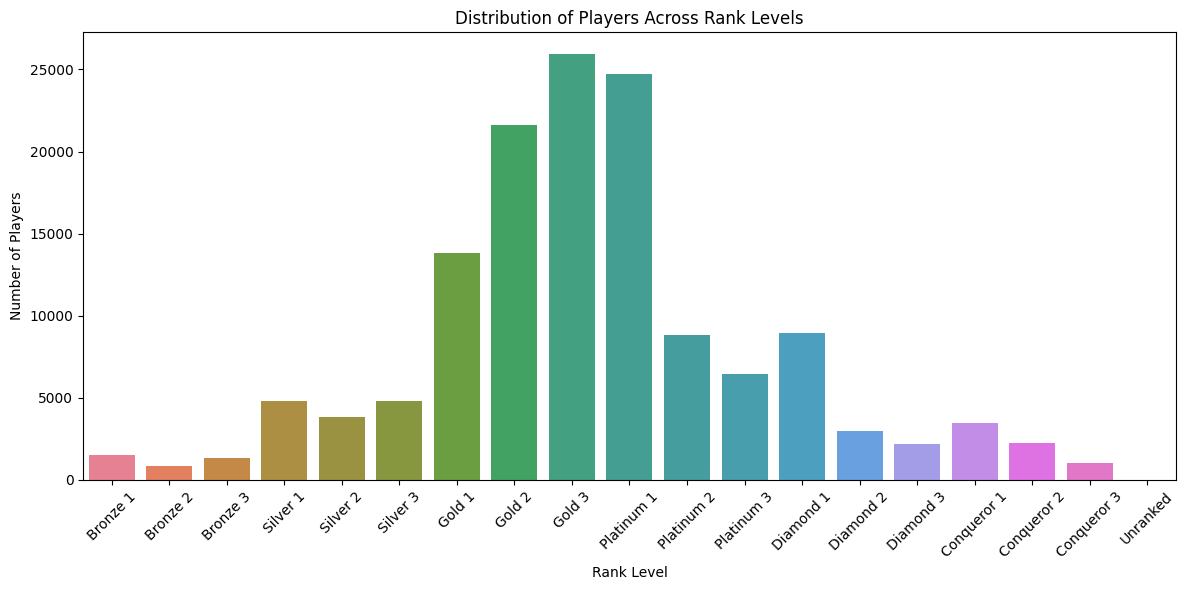

In [42]:
# Count the number of players in each rank level
rank_counts = leaderboard_df["rank_level"].value_counts().reset_index()
rank_counts.columns = ["rank_level", "player_count"]

# Sort the ranks
rank_order = [
    "Bronze 1", "Bronze 2", "Bronze 3",
    "Silver 1", "Silver 2", "Silver 3",
    "Gold 1", "Gold 2", "Gold 3",
    "Platinum 1", "Platinum 2", "Platinum 3",
    "Diamond 1", "Diamond 2", "Diamond 3",
    "Conqueror 1", "Conqueror 2", "Conqueror 3",
    "Unranked"
]

# Ensure all ranks are included in the order
rank_counts["rank_level"] = pd.Categorical(rank_counts["rank_level"], categories=rank_order, ordered=True)
rank_counts.sort_values("rank_level", inplace=True)

print("Number of players in each rank level:")
display(rank_counts)

plt.figure(figsize=(12, 6))
sns.barplot(data=rank_counts, x="rank_level", y="player_count", hue="rank_level", dodge=False)
plt.title("Distribution of Players Across Rank Levels")
plt.xlabel("Rank Level")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Player Win Rates

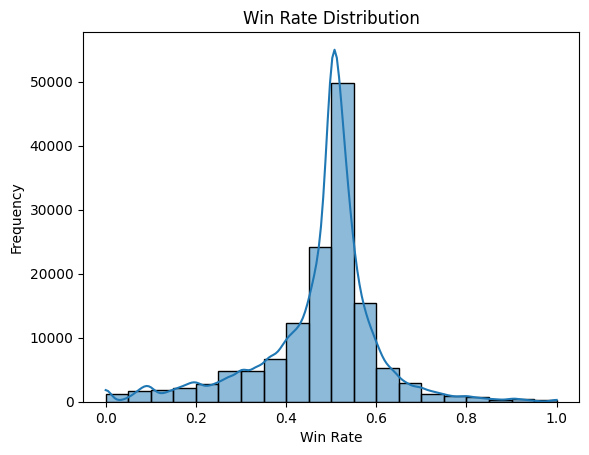

In [26]:
sns.histplot(leaderboard_df["win_rate"], kde=True, bins=20)
plt.title("Win Rate Distribution")
plt.xlabel("Win Rate")
plt.ylabel("Frequency")
plt.show()

#### Average Win Rate by Rank Level

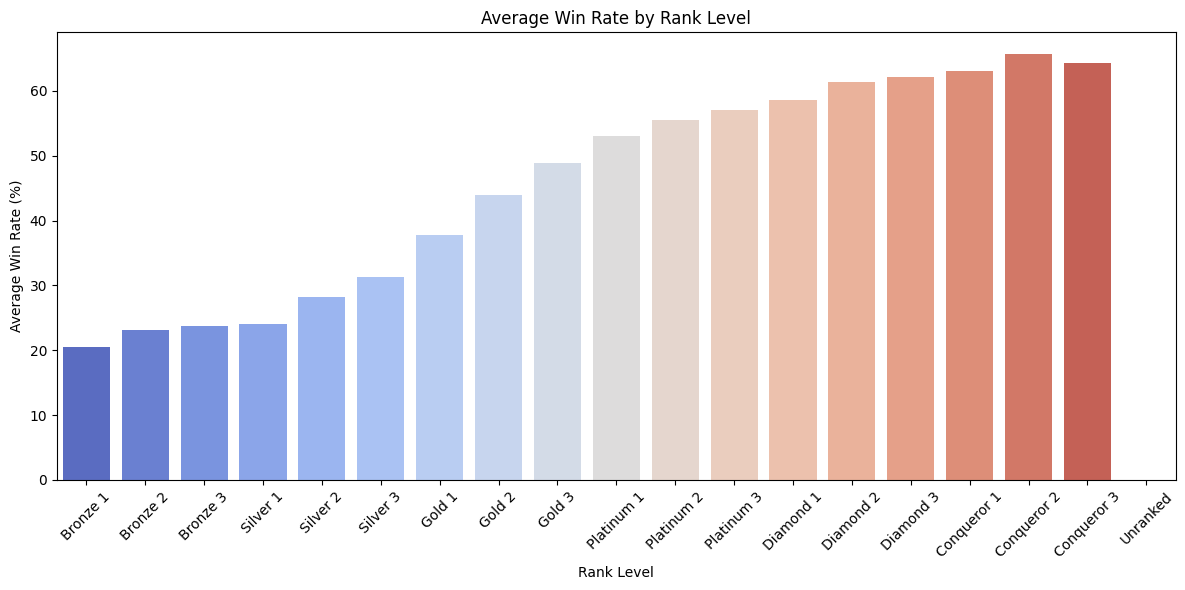

In [ ]:
# Calculate average win rate for each rank level
win_rate_by_rank = leaderboard_df.groupby("rank_level")["win_rate"].mean().reset_index()

# Ensure rank levels are ordered
win_rate_by_rank["rank_level"] = pd.Categorical(win_rate_by_rank["rank_level"], categories=rank_order, ordered=True)
win_rate_by_rank.sort_values("rank_level", inplace=True)

# Convert win rate to percentage
win_rate_by_rank["win_rate_percentage"] = win_rate_by_rank["win_rate"] * 100

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=win_rate_by_rank, x="rank_level", y="win_rate_percentage", hue="rank_level", dodge=False, palette="coolwarm")
plt.title("Average Win Rate by Rank Level")
plt.xlabel("Rank Level")
plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. Relationship Between MMR and Games Played

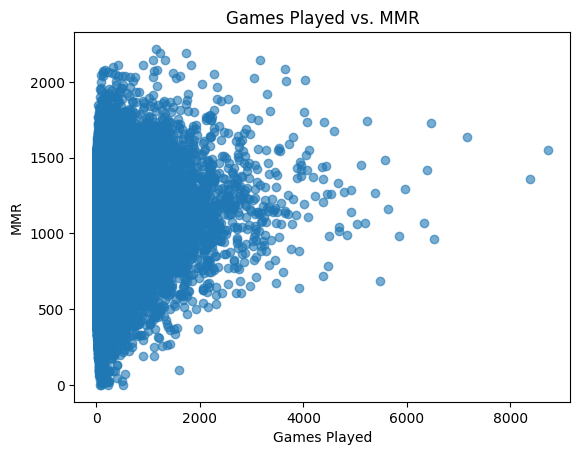

In [27]:
plt.scatter(leaderboard_df["games_count"], leaderboard_df["rating"], alpha=0.6)
plt.title("Games Played vs. MMR")
plt.xlabel("Games Played")
plt.ylabel("MMR")
plt.show()

# Standardize and Extract Features for training the model
### Normalize the features in the `players_df` dataset

In [8]:
from sklearn.discriminant_analysis import StandardScaler

numerical_cols = [
    "rating", "games_count", "wins_count",
    "avg_mmr_diff_10", "avg_mmr_diff_50",
    "avg_mmr", "avg_opp_mmr", "avg_game_length",
    "win_rate"
]

# Normalize the player numerical features
player_features = players_df[numerical_cols].copy()

scaler = StandardScaler()
player_features_scaled = scaler.fit_transform(player_features)

# Convert the scaled array back to DataFrame for convenience
player_features_scaled = pd.DataFrame(player_features_scaled, columns=numerical_cols, index=players_df.index)

# Now append the categorical feature
player_features_scaled["rank_level_encoded"] = players_df["rank_level_encoded"].values

print("The shape of player features:", player_features_scaled.shape)
print("The first 5 rows of scaled player features:")
display(player_features_scaled.head())

The shape of player features: (139492, 10)
The first 5 rows of scaled player features:


,rating,games_count,wins_count,avg_mmr_diff_10,avg_mmr_diff_50,avg_mmr,avg_opp_mmr,avg_game_length,win_rate,rank_level_encoded
0,5.175177,3.728765,4.897620,0.300267,0.156514,3.632811,3.187439,0.553487,1.294730,17
1,5.075707,5.864730,10.223240,0.695962,0.087455,3.817920,3.230100,1.160734,2.855645,17
2,5.050840,3.989338,7.105804,-0.522779,-0.460240,3.717640,2.943949,0.478121,2.889094,17
3,4.885057,11.068852,15.685970,-0.174567,-0.007914,3.674649,2.762841,0.817824,1.766693,17
4,4.880912,3.468192,5.575951,0.379406,0.492298,3.480382,2.811338,0.736907,2.266147,17


### Normalize the features in the `matches_df` dataset

In [9]:
numerical_cols = [
    "rating_A", "win_rate_A", "games_count_A",
    "avg_mmr_diff_10_A", "avg_mmr_diff_50_A", "avg_mmr_A",
    "avg_opp_mmr_A", "avg_game_length_A",
    "rating_B", "win_rate_B", "games_count_B",
    "avg_mmr_diff_10_B", "avg_mmr_diff_50_B", "avg_mmr_B",
    "avg_opp_mmr_B", "avg_game_length_B"
]

# Normalize the match features
match_features = matches_df[numerical_cols].copy()
scaler = StandardScaler()

match_features_scaled = scaler.fit_transform(match_features)

# Convert the scaled array back to DataFrame for convenience
match_features_scaled = pd.DataFrame(match_features_scaled, columns=numerical_cols, index=matches_df.index)

# Now append the categorical feature
match_features_scaled["rank_level_encoded_A"] = matches_df["rank_level_encoded_A"].values
match_features_scaled["rank_level_encoded_B"] = matches_df["rank_level_encoded_B"].values
match_features_scaled["outcome_A"] = matches_df["outcome_A"].values

print("The shape of match features:", match_features_scaled.shape)
print("The first 5 rows of scaled match features:")
display(match_features_scaled.head())

The shape of match features: (1018525, 19)
The first 5 rows of scaled match features:


,rating_A,win_rate_A,games_count_A,avg_mmr_diff_10_A,avg_mmr_diff_50_A,avg_mmr_A,avg_opp_mmr_A,avg_game_length_A,rating_B,win_rate_B,games_count_B,avg_mmr_diff_10_B,avg_mmr_diff_50_B,avg_mmr_B,avg_opp_mmr_B,avg_game_length_B,rank_level_encoded_A,rank_level_encoded_B,outcome_A
0,-0.244373,-0.023050,3.239976,-0.126216,-0.034320,-0.146819,-0.681503,1.445264,0.206038,0.046529,0.072319,-0.088381,-0.099615,0.157779,0.294851,-0.898049,8.0,10.0,0
2,-0.705011,0.100394,-0.471583,1.947427,0.381233,-0.740503,-0.772552,-0.225399,-1.251380,-0.123449,0.848779,-0.643914,-0.356961,-1.087267,-1.197140,0.511260,7.0,6.0,1
3,-1.404895,-0.334821,-0.432596,-0.579825,-0.767575,-1.144896,-1.572260,2.177765,-1.347555,-0.882854,-0.644888,-0.678635,-0.046632,-1.172816,-1.148965,-0.455076,4.0,5.0,1
4,-0.655019,-0.075116,-0.455989,-0.612226,-0.000258,-0.619578,-0.638066,-0.033801,-0.626244,-0.110796,-0.743643,-0.227264,-0.235857,-0.474526,-0.631087,-0.631743,7.0,7.0,0
5,-0.933544,-0.074063,0.201592,-0.255819,-0.026269,-0.654127,-0.721716,1.716407,-0.874079,-0.158809,0.508075,-0.695995,-0.097693,-0.640728,-0.725192,0.484700,6.0,7.0,0


# Building Models
## Predicting Match Outcomes
First, we will build a model to predict the outcome of a match based on the player's features. 
This is a binary classification task, where the target variable is the `result` column in the `matches_df` dataset.
It's a helpful feature for the matchmaking system to predict the outcome of a match before it starts and we can use it to balance the pairings.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier

# Identify features and target
target = "outcome_A"
id_cols = ["profile_id_A", "profile_id_B", "outcome_A"]
features = [col for col in matches_df.columns if col not in id_cols]

print("Features used in the model:")
print(features)

X = matches_df[features]
y = matches_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBClassifier with some basic parameters. You can tune these.
classifier_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

# Train the model
classifier_model.fit(X_train, y_train)

# Predict probabilities for evaluation
y_pred_proba = classifier_model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy XGBClassifier: {accuracy:.4f}")
print(f"AUC XGBClassifier: {auc:.4f}")

Features used in the model:
['rating_A', 'win_rate_A', 'games_count_A', 'wins_count_A', 'rank_level_encoded_A', 'avg_mmr_diff_10_A', 'avg_mmr_diff_50_A', 'avg_mmr_A', 'avg_opp_mmr_A', 'avg_game_length_A', 'rating_B', 'win_rate_B', 'games_count_B', 'wins_count_B', 'rank_level_encoded_B', 'avg_mmr_diff_10_B', 'avg_mmr_diff_50_B', 'avg_mmr_B', 'avg_opp_mmr_B', 'avg_game_length_B']


c:\Users\admin\source\repos\aoe4-matchmaking\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy XGBClassifier: 0.6663
AUC XGBClassifier: 0.7285


### Feature Importance

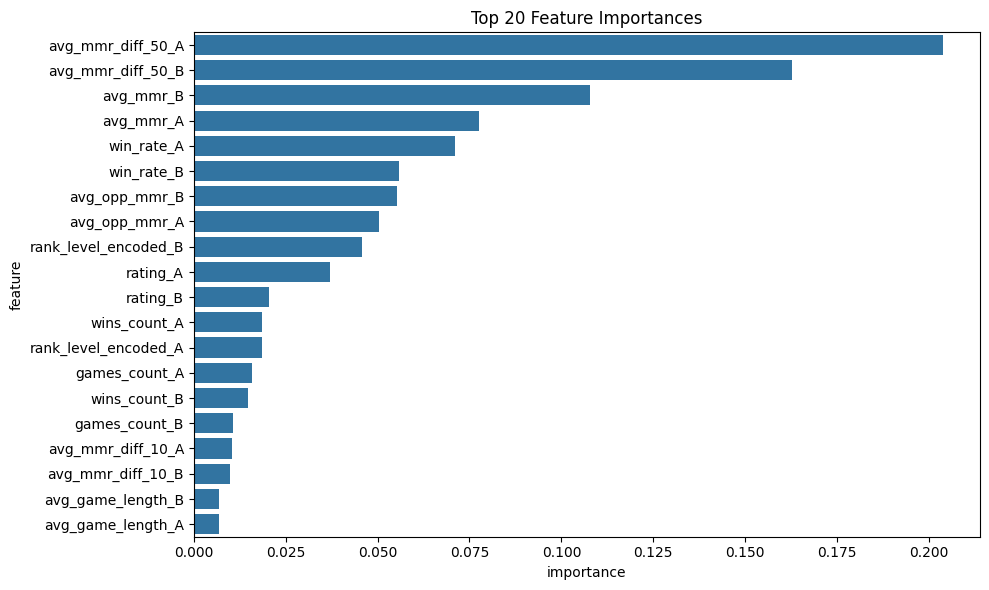

In [13]:
feature_importances = classifier_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feature_importance_df.head(20))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [14]:
import joblib
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.5, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

# Use RandomizedSearchCV to try out a broad range of parameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter settings sampled
    scoring="roc_auc",  # or "accuracy"
    cv=3,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # use all available CPU cores
)

random_search.fit(X_train, y_train)

display(pd.DataFrame(random_search.cv_results_))

# Print the best parameters found
print("Best parameters found for the XGBClassifier: ", random_search.best_params_)

# Evaluate using the best model
classifier_best_model = random_search.best_estimator_
y_pred_proba = classifier_best_model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy with best params: {accuracy:.4f}")
print(f"AUC with best params: {auc:.4f}")

# Save the best model
joblib.dump(classifier_best_model, "../models/classifier_model.joblib")
print("Model saved successfully to models/classifier_model.joblib")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\admin\source\repos\aoe4-matchmaking\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.251616,0.119484,1.128543,0.039416,1.0,1.5,1.0,200,5,0.01,1,0.5,"{'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alp...",0.698685,0.696406,0.695160,0.696750,0.001460,15
1,9.708829,0.108319,0.622061,0.022798,1.0,2.0,0.1,200,3,0.05,1,1.0,"{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha...",0.721913,0.720277,0.719485,0.720558,0.001011,8
2,15.918451,0.286432,1.086399,0.015852,0.5,2.0,0.1,200,5,0.01,1,1.0,"{'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha...",0.698366,0.697239,0.697332,0.697646,0.000511,13
3,9.319006,0.024202,0.635365,0.004362,0.8,2.0,0.0,100,5,0.01,1,1.0,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",0.666642,0.664272,0.662090,0.664335,0.001859,19
4,15.650270,0.055874,1.092512,0.008271,0.8,1.0,1.0,200,5,0.01,5,0.8,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...",0.698676,0.695345,0.694488,0.696170,0.001806,16
5,8.575277,0.683110,0.921493,0.058140,1.0,1.5,0.1,100,7,0.01,1,0.8,"{'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alp...",0.701170,0.697003,0.696566,0.698247,0.002075,12
6,19.776575,0.047114,1.540866,0.006360,0.8,1.0,0.1,300,5,0.10,1,1.0,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...",0.731646,0.730088,0.728669,0.730135,0.001216,2
7,17.749297,0.056452,1.777996,0.122741,0.8,1.0,0.0,200,7,0.05,5,1.0,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...",0.731110,0.729647,0.728293,0.729684,0.001150,3
8,25.013949,0.298079,2.757114,0.076794,0.8,2.0,0.0,300,7,0.05,0,0.5,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",0.730931,0.729240,0.728109,0.729427,0.001160,4
9,28.428414,0.327705,2.571953,0.042345,0.5,2.0,0.1,300,7,0.01,1,1.0,"{'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha...",0.724954,0.722967,0.722111,0.723344,0.001191,7


Best parameters found for the XGBClassifier:  {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 1.0}
Accuracy with best params: 0.6670
AUC with best params: 0.7311
Model saved successfully to models/classifier_model.joblib


### Try Different Models
#### RandomForestClassifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with some basic parameters. You can tune these.
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities for evaluation
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy RandomForestClassifier: {accuracy:.4f}")
print(f"AUC RandomForestClassifier: {auc:.4f}")

Accuracy RandomForestClassifier: 0.6670
AUC RandomForestClassifier: 0.7054


#### LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize LogisticRegression
logreg_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

# Train the model
logreg_model.fit(X_train_scaled, y_train)

# Predict probabilities for evaluation
X_test_scaled = scaler.transform(X_test)
y_pred_proba = logreg_model.predict_proba(X_test_scaled)[:,1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy LogisticRegression: {accuracy:.4f}")
print(f"AUC LogisticRegression: {auc:.4f}")

Accuracy LogisticRegression: 0.6670
AUC LogisticRegression: 0.7174


## Clustering Players

In [ ]:
from sklearn.cluster import KMeans

# Clustering using KMeans
kmeans = KMeans(n_clusters=54, random_state=42)
cluster_labels = kmeans.fit_predict(player_features_scaled)

players_df["cluster"] = cluster_labels

print("Total number of clusters:", len(players_df["cluster"].unique()))
display(players_df.head())

# Save the clustered players data
players_df.to_csv("../models/clustered_players.csv", index=False)

Total number of clusters: 25


,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country,rank_level_encoded,avg_mmr_diff_10,avg_mmr_diff_50,avg_mmr,avg_opp_mmr,avg_game_length,common_civ,win_rate,cluster
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,Conqueror 3,by,17,1.7,0.660000,2142.573770,1956.5,1043.9,zhu_xis_legacy,0.648485,8
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,Conqueror 3,rs,17,4.2,0.240000,2233.368687,1977.7,1536.2,delhi_sultanate,0.856074,8
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,Conqueror 3,es,17,-3.5,-3.090909,2184.181818,1835.5,982.8,ayyubids,0.860522,8
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,Conqueror 3,cn,17,-1.3,-0.340000,2163.094891,1745.5,1258.2,japanese,0.711252,16
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,Conqueror 3,ca,17,2.2,2.702128,2067.808511,1769.6,1192.6,japanese,0.777675,8


### Visualizing Clusters

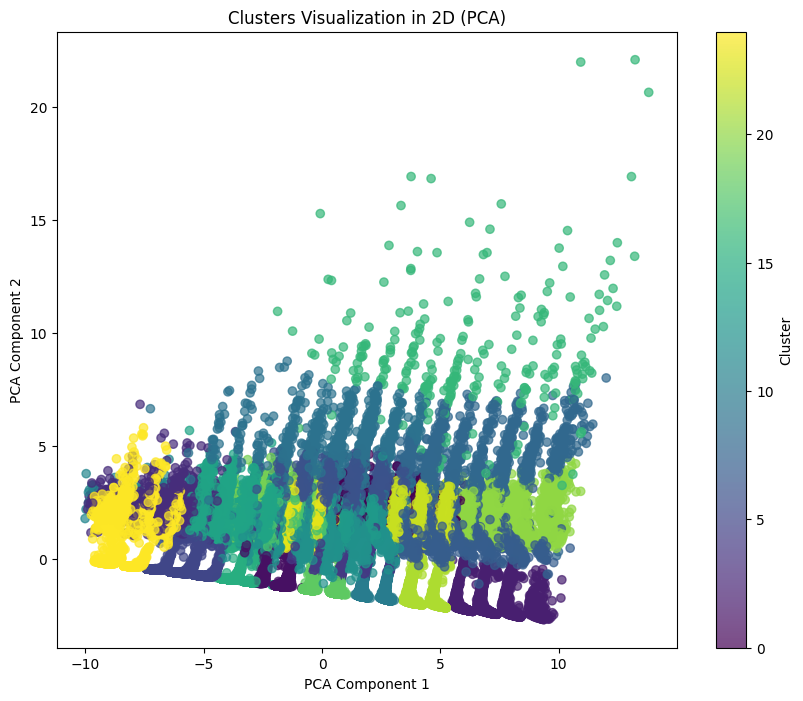

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
player_features_2d = pca.fit_transform(player_features_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(player_features_2d[:, 0], player_features_2d[:, 1], c=players_df["cluster"], cmap="viridis", alpha=0.7)

# Add cluster labels to the plot
plt.colorbar(scatter, label="Cluster")
plt.title("Clusters Visualization in 2D (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

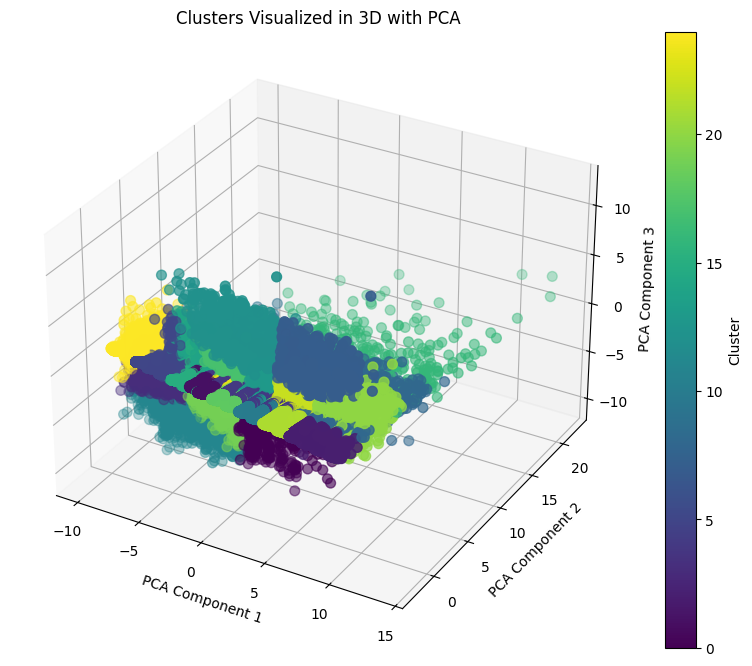

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce to 3D
pca = PCA(n_components=3)
pca_components = pca.fit_transform(player_features_scaled)

# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax: Axes3D = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=players_df["cluster"], cmap="viridis", s=50)
ax.set_title("Clusters Visualized in 3D with PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
fig.colorbar(scatter, label="Cluster")
plt.show()

#### Try HDSCAN Clustering Algorithm

In [ ]:
from hdbscan import HDBSCAN

players_copy = players_df.copy()

# Clustering using HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=10)
cluster_labels = hdbscan.fit_predict(player_features_scaled)

players_copy["hdbscan_cluster"] = cluster_labels

print("Total number of clusters:", len(players_copy["hdbscan_cluster"].unique()))

# Cluster outliers are labeled as -1
print("Number of outliers:", (players_copy["hdbscan_cluster"] == -1).sum())

display(players_copy.head())

Total number of clusters: 1101
Number of outliers: 40682


,rank,name,profile_id,rating,games_count,wins_count,last_game_at,rank_level,country,rank_level_encoded,avg_mmr_diff_10,avg_mmr_diff_50,avg_mmr,avg_opp_mmr,avg_game_length,common_civ,win_rate,hdbscan_cluster
0,1,Fox.Anotand,8432378,2217,1155,749,2024-12-03 20:39:41 UTC,Conqueror 3,by,17,1.7,0.660000,2142.573770,1956.5,1043.9,zhu_xis_legacy,0.648485,-1
1,2,Beasty,1270139,2193,1737,1487,2024-12-04 18:24:45 UTC,Conqueror 3,rs,17,4.2,0.240000,2233.368687,1977.7,1536.2,delhi_sultanate,0.856074,-1
2,3,El Sensei,5364911,2187,1226,1055,2024-11-29 14:47:54 UTC,Conqueror 3,es,17,-3.5,-3.090909,2184.181818,1835.5,982.8,ayyubids,0.860522,-1
3,4,EL.loueMT,8354416,2147,3155,2244,2024-12-04 03:57:44 UTC,Conqueror 3,cn,17,-1.3,-0.340000,2163.094891,1745.5,1258.2,japanese,0.711252,-1
4,5,1puppypaw,8446710,2146,1084,843,2024-12-02 00:56:15 UTC,Conqueror 3,ca,17,2.2,2.702128,2067.808511,1769.6,1192.6,japanese,0.777675,-1
